In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the numbe of classes required to detect
        self.add_class("custom", 1, "Topi")
        self.add_class("custom",2,"Baju")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions a...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_maskRCNN_1/train/labels/labels_train_VGG.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #labelling each class in the given image to a number

            custom = [s['region_attributes'] for s in a['regions'].values()]
            
            num_ids=[]
            #Add the classes according to the requirement
            for n in custom:
                try:
                    if n['label']=='Topi':
                        num_ids.append(1)
                    elif n['label']=='Baju':
                        num_ids.append(2)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "custom",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [3]:
dataset_train = CustomDataset()
dataset_train.load_custom("C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_maskRCNN_1", "train") 
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))



# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

Train: 27


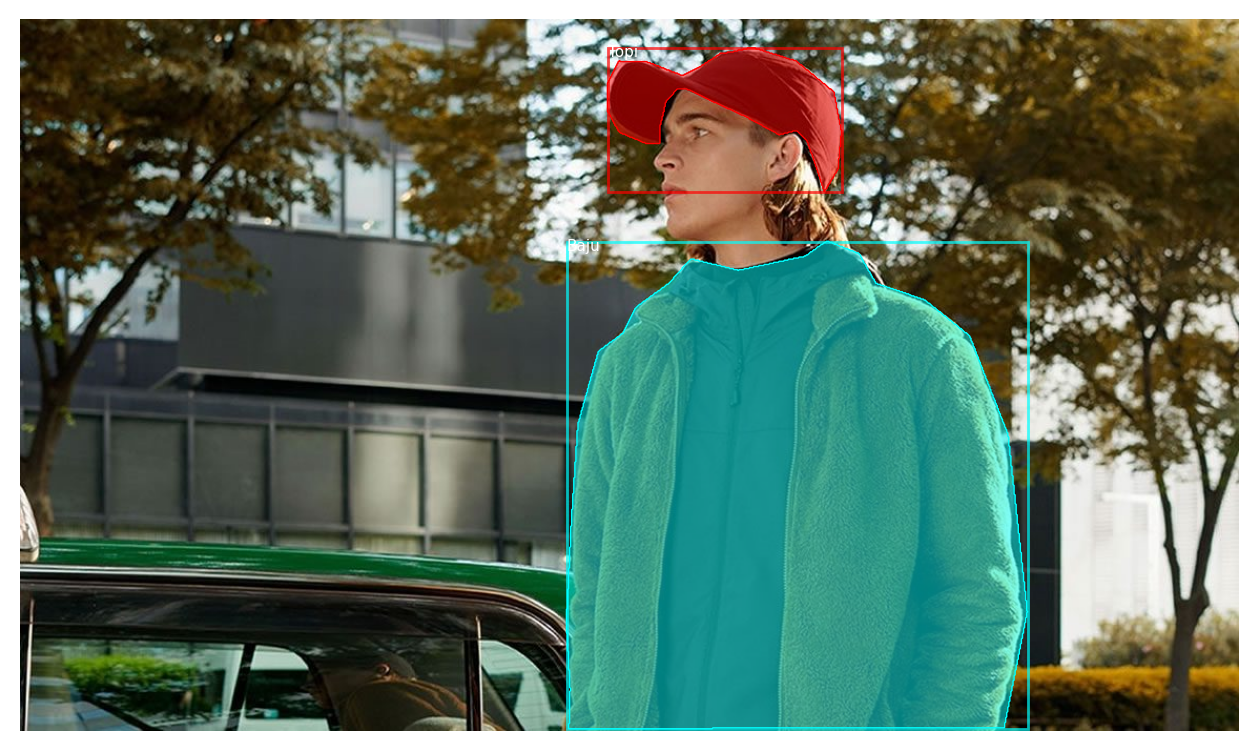


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class PakaianConfig(Config):
	# define the name of the configuration
	NAME = "pakaian_cfg"
	# number of classes (background + blue marble + non-Blue marble)
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = PakaianConfig()
config.display() 

In [3]:
import os
import sys
import json
import numpy as np
import skimage.draw
import skimage.io
from pycocotools.coco import COCO
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot as plt

class CustomDataset(Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the COCO dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Load the COCO annotation file
        annotation_path = os.path.join(dataset_dir, f"C:/Users/judit\Downloads/coba/Mask-RCNN-TF2/dataset1/train/labels/COCO.json")
        coco = COCO(annotation_path)

        # Add classes
        class_ids = sorted(coco.getCatIds())
        for class_id in class_ids:
            self.add_class("custom", class_id, coco.loadCats(class_id)[1]["Topi"])
            self.add_class("custom", class_id, coco.loadCats(class_id)[2]["Pakaian"])
            self.add_class("custom", class_id, coco.loadCats(class_id)[3]["Meja"])
            self.add_class("custom", class_id, coco.loadCats(class_id)[4]["Cangkir"])

        # Load images
        image_ids = coco.getImgIds()
        for image_id in image_ids:
            image_info = coco.loadImgs(image_id)[0]
            self.add_image(
                "custom",
                image_id=image_id,
                path=os.path.join(dataset_dir, subset, image_info['C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset1/train']),
                width=image_info['width'],
                height=image_info['height'],
                annotations=coco.loadAnns(coco.getAnnIds(imgIds=[image_id], iscrowd=False))
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = image_info["annotations"]

        for annotation in annotations:
            class_id = annotation["category_id"]
            mask = self.ann_to_mask(annotation, image_info["height"], image_info["width"])
            if mask.max() < 1:
                continue
            instance_masks.append(mask)
            class_ids.append(class_id)

        if class_ids:
            masks = np.stack(instance_masks, axis=-1)
            class_ids = np.array(class_ids, dtype=np.int32)
            return masks, class_ids
        else:
            return super(self.__class__, self).load_mask(image_id)

    def ann_to_mask(self, ann, height, width):
        """Convert annotation to mask."""
        mask = np.zeros((height, width), dtype=np.uint8)
        for seg in ann['segmentation']:
            rr, cc = skimage.draw.polygon(np.array(seg).reshape(-1, 2)[:, 1], np.array(seg).reshape(-1, 2)[:, 0])
            mask[rr, cc] = 1
        return mask

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Define dataset directory
dataset_dir = "C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset1"

# Load training dataset
dataset_train = CustomDataset()
dataset_train.load_custom(dataset_dir, "train")
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))

# Define image id
image_id = dataset_train.image_ids[0]

# Load the image
image = dataset_train.load_image(image_id)

# Load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# Extract bounding boxes from the masks
bbox = extract_bboxes(mask)

# Display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Define a configuration for the model
class PakaianConfig(Config):
    NAME = "pakaian_cfg"
    NUM_CLASSES = 1 + len(dataset_train.class_names)  # Background + classes
    STEPS_PER_EPOCH = 100
    # DETECTION_MIN_CONFIDENCE = 0.9  # Skip detections with < 90% confidence

# Prepare config
config = PakaianConfig()
config.display()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


IndexError: list index out of range

In [5]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/coco_weights/mask_rcnn_coco.h5")

In [6]:
########################
#Weights are saved to root D: directory. need to investigate how they can be
#saved to the directory defined... "logs_models"

###############

# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=25, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /logdir/train\mask_rcnn_pakaian_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribute

C:\Users\judit\anaconda3\envs\maskrcnn_2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
  1/100 [..............................] - ETA: 1:30:00 - loss: 7.3679

KeyboardInterrupt: 

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 28 00:36:22 2024

@author: judit
"""
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils
############################
#INFERENCE

###################################################
from mrcnn.config import Config
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle


# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "pakaian_cfg"
	# number of classes (background + Blue Marbles + Non Blue marbles)
	NUM_CLASSES = 1 + 2
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
 
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='C:/Users/judit/Downloads/coba/Mask-RCNN-TF2', config=cfg)
# load model weights
model.load_weights('C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/mask_rcnn_coco.h5', by_name=True)
# evaluate model on training dataset
# train_mAP = evaluate_model(dataset_train, model, cfg)
# print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# test_mAP = evaluate_model(dataset_train, model, cfg)
# print("Test mAP: %.3f" % test_mAP)

#################################################
#Test on a single image
marbles_img = skimage.io.imread("C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_maskRCNN_1/val/test5.jpg")
plt.imshow(marbles_img)

detected = model.detect([marbles_img])
results = detected[0]
class_names = ['BG', 'Topi', 'Baju']
display_instances(marbles_img, results['rois'], results['masks'], 
                   results['class_ids'], class_names, results['scores'])

###############################


##############################################

#Show detected objects in color and all others in B&W    
# def color_splash(img, mask):
#     """Apply color splash effect.
#     image: RGB image [height, width, 3]
#     mask: instance segmentation mask [height, width, instance count]
#     Returns result image.
#     """
#     # Make a grayscale copy of the image. The grayscale copy still
#     # has 3 RGB channels, though.
#     gray = skimage.color.gray2rgb(skimage.color.rgb2gray(img)) * 255
#     # Copy color pixels from the original color image where mask is set
#     if mask.shape[-1] > 0:
#         # We're treating all instances as one, so collapse the mask into one layer
#         mask = (np.sum(mask, -1, keepdims=True) >= 1)
#         splash = np.where(mask, img, gray).astype(np.uint8)
#     else:
#         splash = gray.astype(np.uint8)
#     return splash

# import skimage
# def detect_and_color_splash(model, image_path=None, video_path=None):
#     assert image_path or video_path

#     # Image or video?
#     if image_path:
#         # Run model detection and generate the color splash effect
#         #print("Running on {}".format(img))
#         # Read image
#         img = skimage.io.imread(image_path)
#         # Detect objects
#         r = model.detect([img], verbose=1)[0]
#         # Color splash
#         splash = color_splash(img, r['masks'])
#         # Save output
#         file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
#         skimage.io.imsave(file_name, splash)
#     elif video_path:
#         import cv2
#         # Video capture
#         vcapture = cv2.VideoCapture(video_path)
#         width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
#         height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
#         fps = vcapture.get(cv2.CAP_PROP_FPS)

#         # Define codec and create video writer
#         file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
#         vwriter = cv2.VideoWriter(file_name,
#                                   cv2.VideoWriter_fourcc(*'MJPG'),
#                                   fps, (width, height))

#         count = 0
#         success = True
#         while success:
#             print("frame: ", count)
#             # Read next image
#             success, img = vcapture.read()
#             if success:
#                 # OpenCV returns images as BGR, convert to RGB
#                 img = img[..., ::-1]
#                 # Detect objects
#                 r = model.detect([img], verbose=0)[0]
#                 # Color splash
#                 splash = color_splash(img, r['masks'])
#                 # RGB -> BGR to save image to video
#                 splash = splash[..., ::-1]
#                 # Add image to video writer
#                 vwriter.write(splash)
#                 count += 1
#         vwriter.release()
#     print("Saved to ", file_name)

# detect_and_color_splash(model, image_path="C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_maskRCNN_1/val/test1.jpg")

######################################################

ValueError: Layer #389 (named "mrcnn_bbox_fc"), weight <tf.Variable 'mrcnn_bbox_fc_10/kernel:0' shape=(1024, 12) dtype=float32, numpy=
array([[ 0.03283913,  0.06917916,  0.04873513, ...,  0.04653534,
        -0.06789157, -0.04269064],
       [-0.01332314, -0.06283257,  0.00087927, ...,  0.06802027,
         0.03322025,  0.00808161],
       [-0.02574173, -0.0558513 , -0.02857931, ..., -0.00570515,
         0.06657332,  0.03238817],
       ...,
       [ 0.02661601, -0.06409439,  0.04673509, ..., -0.00931288,
        -0.04565483,  0.07568215],
       [ 0.01996907,  0.01721255, -0.06392089, ..., -0.00302442,
         0.06167844,  0.03355261],
       [ 0.02806057, -0.06493032, -0.04262512, ...,  0.05247585,
         0.06112882,  0.07440536]], dtype=float32)> has shape (1024, 12), but the saved weight has shape (1024, 324).